# **Homework 2**

## **2.1 Loading the MNIST dataset**

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [2]:
( train_ds , test_ds ) , ds_info = tfds.load('mnist', split =[ 'train', 'test'], as_supervised = True , with_info = True )
print(ds_info)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1.incompleteLBE73I',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      

**How many training/test images are there?**
* 10000 test and 60000 train images  

**What’s the image shape?**  
* (28,28,1)

**What range are pixel values in?**
* 0-255

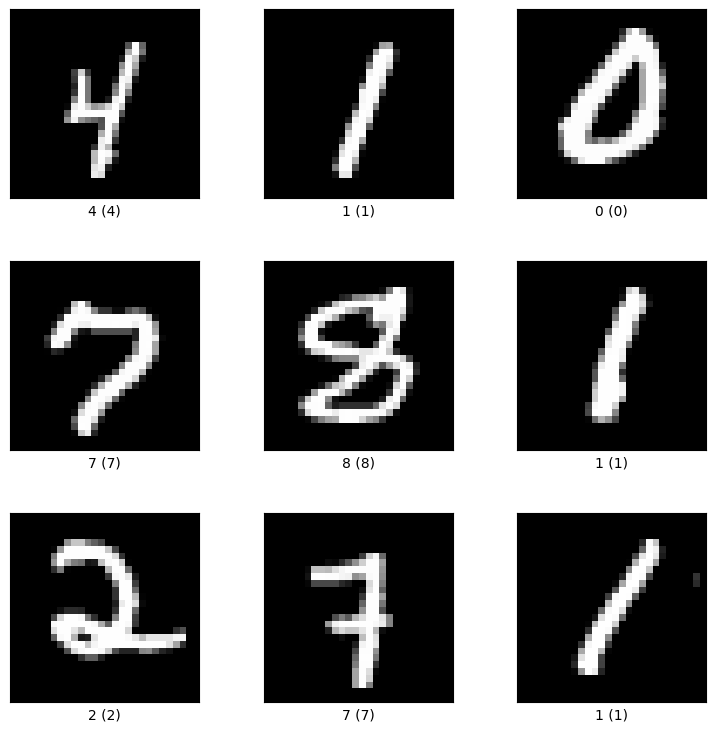

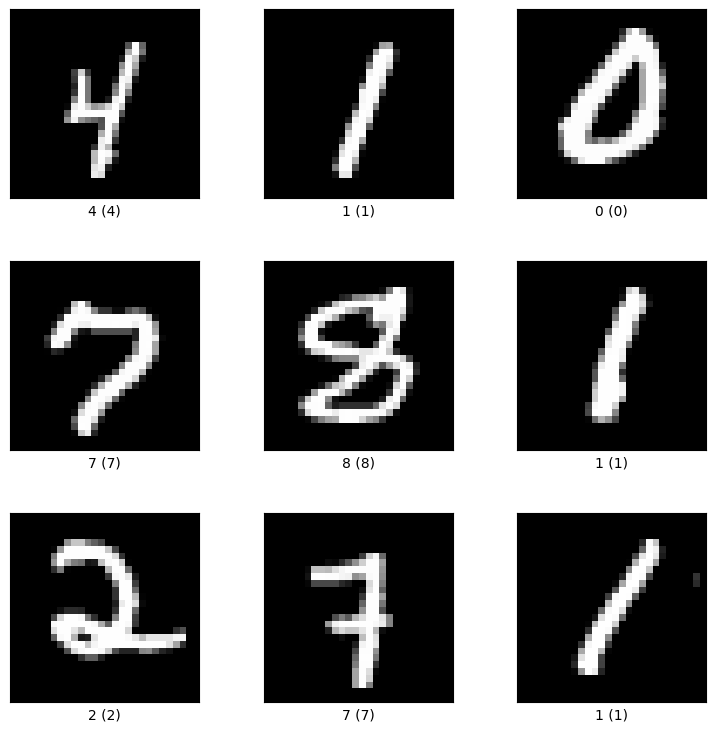

In [ ]:
tfds.show_examples(train_ds , ds_info)

## **2.2 Setting up the data pipeline**

In [3]:
def data_prep(data):
  batch_size = 32
  shuffle_size = 1000
  prefetch_size = 20
  # reshape images
  data = data.map(lambda image, label: (tf.reshape(image, (-1,)), label))
  # scale down respective pixels to range 127 & cast to float
  data = data.map(lambda image, label: ((tf.cast(image, tf.float32)/128)-1, label))
  # one hotify the labels
  data = data.map(lambda image, label: (image, tf.one_hot(label, depth=10)))
  # shuffle data and then batch of the suffled data
  data = data.shuffle(shuffle_size).batch(batch_size)
  # prefetch function, makes sure prefetch_size batches are always ready
  data = data.prefetch(prefetch_size)

  return data

## **2.3 Building a deep neural network with TensorFlow**

In [4]:
class MNIST_Model(tf.keras.Model):

  def __init__(self, layer_sizes, output_size=10):
    super().__init__()
    self.mlp_layers = []
    # create layers
    for layer_size in layer_sizes:
        new_layer = tf.keras.layers.Dense(units=layer_size, activation='relu')
        self.mlp_layers.append(new_layer)
    # output layer
    self.output_layer = tf.keras.layers.Dense(units=output_size, activation='softmax')


  def call(self, x):
    for layer in self.mlp_layers:
      x = layer(x)
    y = self.output_layer(x)
    return y

## **2.4 Training the network**

In [5]:
def train_loop(model, train_ds, test_ds, loss_func, optimizer, num_epochs=10):

  train_losses = []
  train_accuracies = []
  test_losses = []
  test_accuracies = []

  for epoch in range(num_epochs):


    #training
    epoch_losses = []
    epoch_accuracies = []
    for input,target in train_ds:
        loss, accuracy = train_step(model, input, target, loss_func, optimizer)
        epoch_losses.append(loss)
        epoch_accuracies.append(accuracy)

    #track training loss and accuracies
    train_losses.append(tf.reduce_mean(epoch_losses))
    train_accuracies.append(tf.reduce_mean(epoch_accuracies))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test_loop(model, test_ds, loss_func)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f' After epoch {str(epoch)} the accuracy is: {test_accuracies[-1]}')

  return train_losses, train_accuracies, test_losses, test_accuracies

def train_step(model, input, target, loss_function, optimizer):

  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    accuracy = np.mean(accuracy)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return loss, accuracy

def test_loop(model, test_ds, loss_func):
  test_accuracy_agg = []
  test_loss_agg = []

  for (input, target) in test_ds:
    prediction = model(input)
    sample_test_loss = loss_func(target, prediction)
    # sample_test_accuracy hat boolean pro sample in batch (länge ist also wie batch size)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    # mean accuracy for the batch
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_agg.append(sample_test_loss.numpy())
    test_accuracy_agg.append(sample_test_accuracy)


  test_loss = tf.reduce_mean(test_loss_agg)
  test_accuracy = tf.reduce_mean(test_accuracy_agg)

  return test_loss, test_accuracy


In [6]:
# main
train_ds, test_ds = tfds.load('mnist', split =[ 'train', 'test'], as_supervised = True)

# data preperation
train_data = train_ds.apply(data_prep)
test_data = test_ds.apply(data_prep)



In [ ]:
# model
layer_sizes = [256,256]
mnistModel = MNIST_Model(layer_sizes)

# training
loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate)
num_epochs = 10

train_losses, train_accuracies, test_losses, test_accuracies = train_loop(mnistModel, train_data, test_data, loss_func, optimizer, num_epochs)

 After epoch 0 the accuracy is: 0.8591253993610224
 After epoch 1 the accuracy is: 0.889576677316294
 After epoch 2 the accuracy is: 0.9010583067092651
 After epoch 3 the accuracy is: 0.9073482428115016
 After epoch 4 the accuracy is: 0.9137380191693291
 After epoch 5 the accuracy is: 0.9175319488817891
 After epoch 6 the accuracy is: 0.9230231629392971
 After epoch 7 the accuracy is: 0.9249201277955271
 After epoch 8 the accuracy is: 0.928314696485623
 After epoch 9 the accuracy is: 0.9294129392971247


## **2.5 Visualization**

In [7]:
def visualization( train_losses , train_accuracies , test_losses , test_accuracies):


  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))


  # Plot the Loss
  ax1.plot(train_losses, color="purple", label="Train")
  ax1.plot(test_losses, color="skyblue", label="Test")
  ax1.set_title("Train vs. Test Loss")
  ax1.legend()
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  #ax1.show()

  # Plot the Accuracy
  ax2.plot(train_accuracies, color="purple", label="Train")
  ax2.plot(test_accuracies, color="skyblue", label="Test")
  ax2.set_title("Train vs. Test Accuracy")
  ax2.legend()
  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Accuracy")
  plt.show()

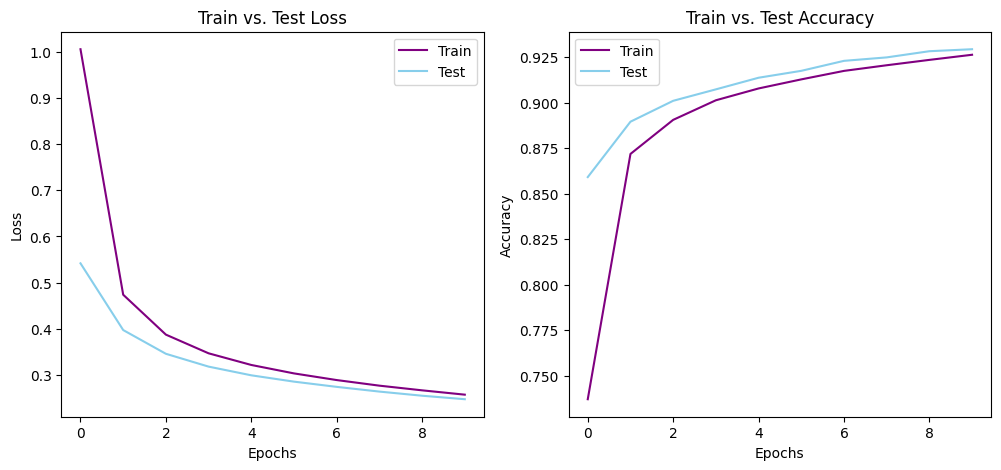

In [ ]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

## **3 Adjusting the hyperparameters of your model**

Base configuration of paramters:
* learning rate: 0.001
* batch size: 32
* layer size [256, 256]
* optimizer: SGD

### changing the learning rate

In [ ]:
# model
layer_sizes = [256,256]
mnistModel = MNIST_Model(layer_sizes)

# training
loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.5
optimizer = tf.keras.optimizers.SGD(learning_rate)
num_epochs = 10

train_losses, train_accuracies, test_losses, test_accuracies = train_loop(mnistModel, train_data, test_data, loss_func, optimizer, num_epochs)

 After epoch 0 the accuracy is: 0.11351837060702875
 After epoch 1 the accuracy is: 0.10263578274760383
 After epoch 2 the accuracy is: 0.1007388178913738
 After epoch 3 the accuracy is: 0.11351837060702875
 After epoch 4 the accuracy is: 0.09814297124600639
 After epoch 5 the accuracy is: 0.1136182108626198
 After epoch 6 the accuracy is: 0.1009384984025559
 After epoch 7 the accuracy is: 0.11331869009584665
 After epoch 8 the accuracy is: 0.10283546325878594
 After epoch 9 the accuracy is: 0.10303514376996806


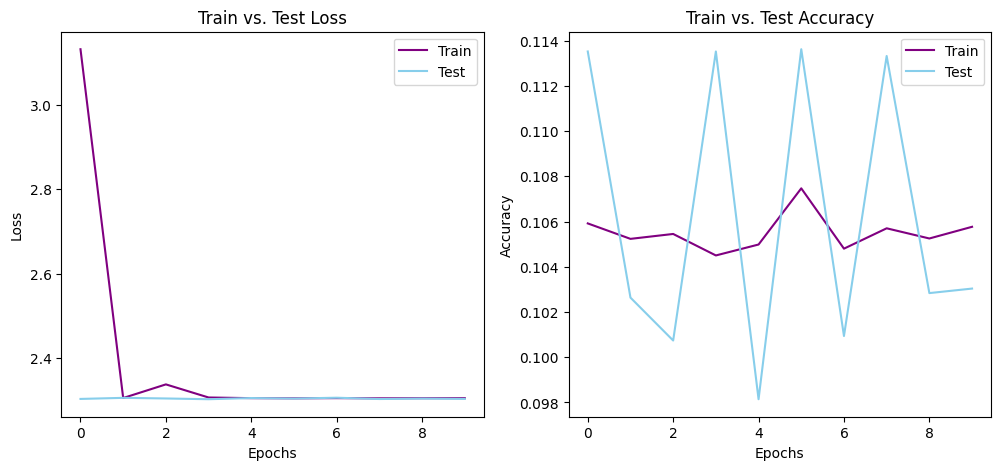

In [ ]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

In [ ]:
# model
layer_sizes = [256,256]
mnistModel = MNIST_Model(layer_sizes)

# training
loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.1
optimizer = tf.keras.optimizers.SGD(learning_rate)
num_epochs = 10

train_losses, train_accuracies, test_losses, test_accuracies = train_loop(mnistModel, train_data, test_data, loss_func, optimizer, num_epochs)

 After epoch 0 the accuracy is: 0.955770766773163
 After epoch 1 the accuracy is: 0.9649560702875399
 After epoch 2 the accuracy is: 0.9710463258785943
 After epoch 3 the accuracy is: 0.9722444089456869
 After epoch 4 the accuracy is: 0.9704472843450479
 After epoch 5 the accuracy is: 0.9763378594249201
 After epoch 6 the accuracy is: 0.9762380191693291
 After epoch 7 the accuracy is: 0.9740415335463258
 After epoch 8 the accuracy is: 0.9711461661341853
 After epoch 9 the accuracy is: 0.9771365814696485


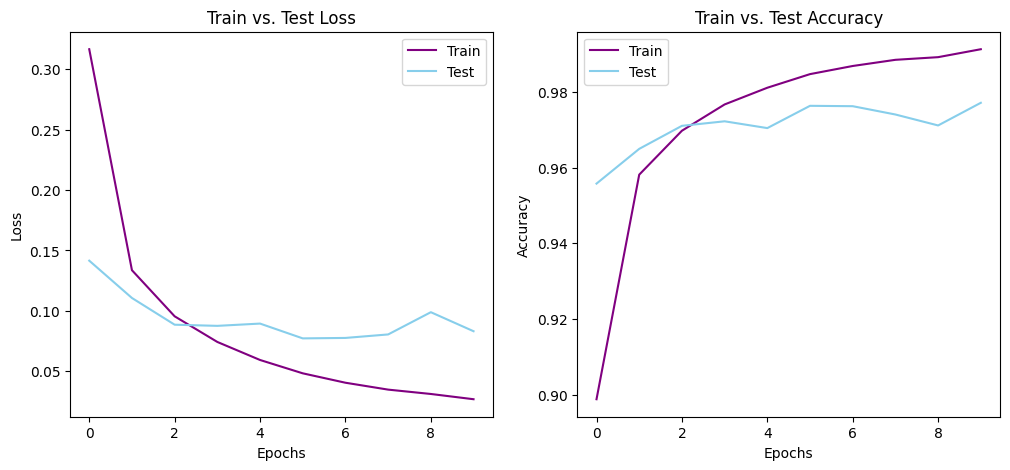

In [ ]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

In [ ]:
# model
layer_sizes = [256,256]
mnistModel = MNIST_Model(layer_sizes)

# training
loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate)
num_epochs = 10

train_losses, train_accuracies, test_losses, test_accuracies = train_loop(mnistModel, train_data, test_data, loss_func, optimizer, num_epochs)

 After epoch 0 the accuracy is: 0.9125399361022364
 After epoch 1 the accuracy is: 0.9460862619808307
 After epoch 2 the accuracy is: 0.952276357827476
 After epoch 3 the accuracy is: 0.9545726837060703
 After epoch 4 the accuracy is: 0.9636581469648562
 After epoch 5 the accuracy is: 0.9644568690095847
 After epoch 6 the accuracy is: 0.9677515974440895
 After epoch 7 the accuracy is: 0.970547124600639
 After epoch 8 the accuracy is: 0.97064696485623
 After epoch 9 the accuracy is: 0.9732428115015974


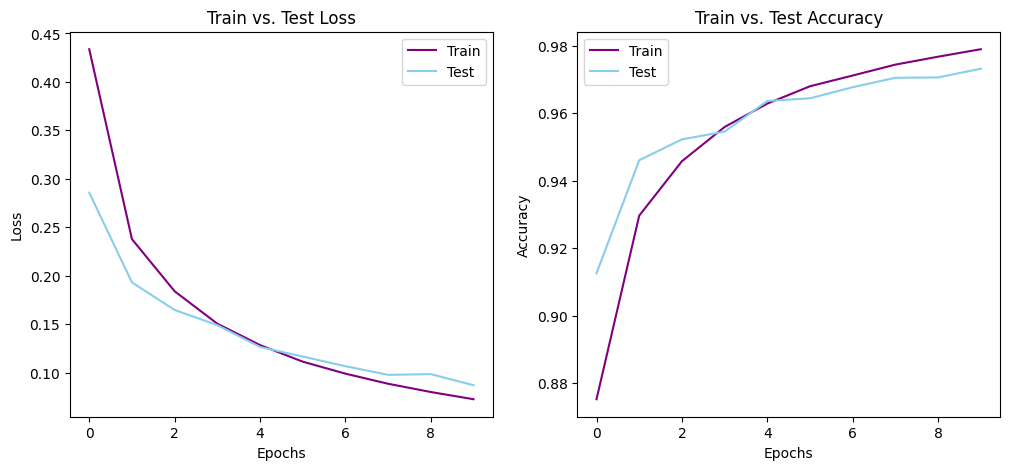

In [ ]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

a high learning rate of 0.5:
* lead to accuracies that are very low (between 0.098-0.1136)
* test accuracy jumps around a lot
* the loss is quite high
* the test loss doesn't change but stays at the same value for every epoch, while the train loss starts higher but then sinks and stays at the same value as the test loss

learning rate of 0.1 and 0.01 comapred to 0.001
* 0.1 and 0.01 have similar accuracies (up to almost 0.98) that are higher than the ones for 0.001
* 0.1 has the lowest loss

### change layers

In [ ]:
# model
layer_sizes = [12,12]
mnistModel = MNIST_Model(layer_sizes)

# training
loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate)
num_epochs = 10

train_losses, train_accuracies, test_losses, test_accuracies = train_loop(mnistModel, train_data, test_data, loss_func, optimizer, num_epochs)

 After epoch 0 the accuracy is: 0.34674520766773165
 After epoch 1 the accuracy is: 0.5042931309904153
 After epoch 2 the accuracy is: 0.6855031948881789
 After epoch 3 the accuracy is: 0.7828474440894568
 After epoch 4 the accuracy is: 0.8340654952076677
 After epoch 5 the accuracy is: 0.8568290734824281
 After epoch 6 the accuracy is: 0.8679113418530351
 After epoch 7 the accuracy is: 0.8737020766773163
 After epoch 8 the accuracy is: 0.8801916932907349
 After epoch 9 the accuracy is: 0.8851837060702875


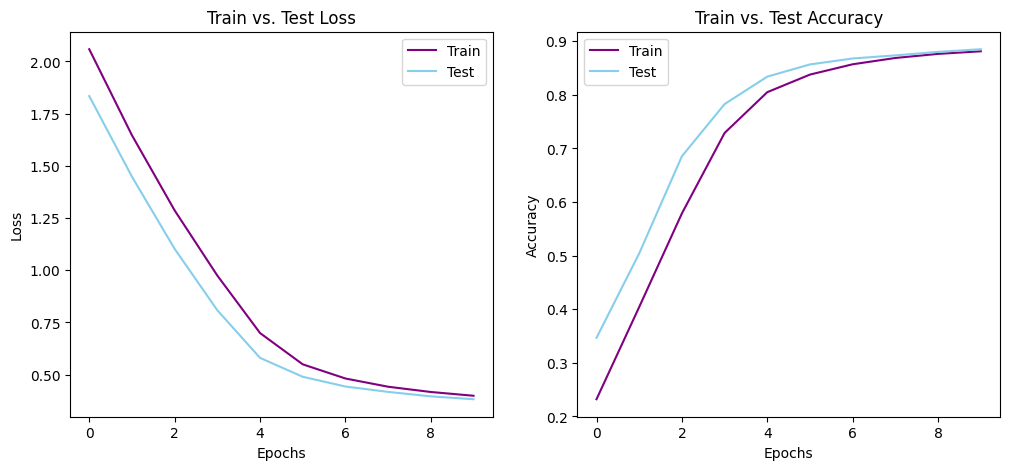

In [ ]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

If size is smaller the code takes shorter to run, but the accuracies are lower and the loss is higher.

In [ ]:
# model
layer_sizes = [256,256, 256]
mnistModel = MNIST_Model(layer_sizes)

# training
loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate)
num_epochs = 10

train_losses, train_accuracies, test_losses, test_accuracies = train_loop(mnistModel, train_data, test_data, loss_func, optimizer, num_epochs)

 After epoch 0 the accuracy is: 0.851138178913738
 After epoch 1 the accuracy is: 0.8882787539936102
 After epoch 2 the accuracy is: 0.9020567092651757
 After epoch 3 the accuracy is: 0.9128394568690096
 After epoch 4 the accuracy is: 0.9169329073482428
 After epoch 5 the accuracy is: 0.9212260383386581
 After epoch 6 the accuracy is: 0.9242212460063898
 After epoch 7 the accuracy is: 0.9289137380191693
 After epoch 8 the accuracy is: 0.9304113418530351
 After epoch 9 the accuracy is: 0.9333067092651757


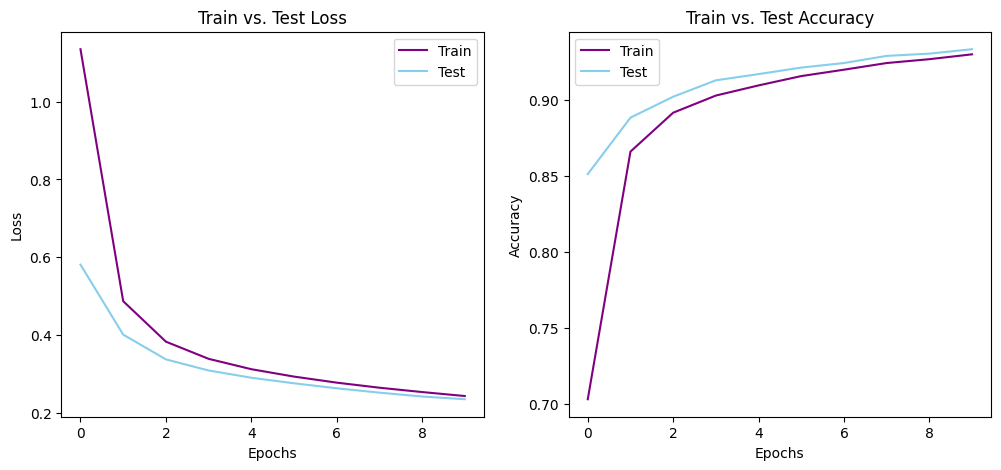

In [ ]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

Adding another layer with size 256 lead to a longer run time but the results don't change much, the accuracy is only a tiny bit higher.

## Change optimizer

In [ ]:
# model
layer_sizes = [256,256]
mnistModel = MNIST_Model(layer_sizes)

# training
loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)
num_epochs = 10

train_losses, train_accuracies, test_losses, test_accuracies = train_loop(mnistModel, train_data, test_data, loss_func, optimizer, num_epochs)

 After epoch 0 the accuracy is: 0.9575678913738019
 After epoch 1 the accuracy is: 0.9583666134185304
 After epoch 2 the accuracy is: 0.9661541533546326
 After epoch 3 the accuracy is: 0.9714456869009584
 After epoch 4 the accuracy is: 0.9686501597444089
 After epoch 5 the accuracy is: 0.9734424920127795
 After epoch 6 the accuracy is: 0.9686501597444089
 After epoch 7 the accuracy is: 0.9734424920127795
 After epoch 8 the accuracy is: 0.9738418530351438
 After epoch 9 the accuracy is: 0.9747404153354633


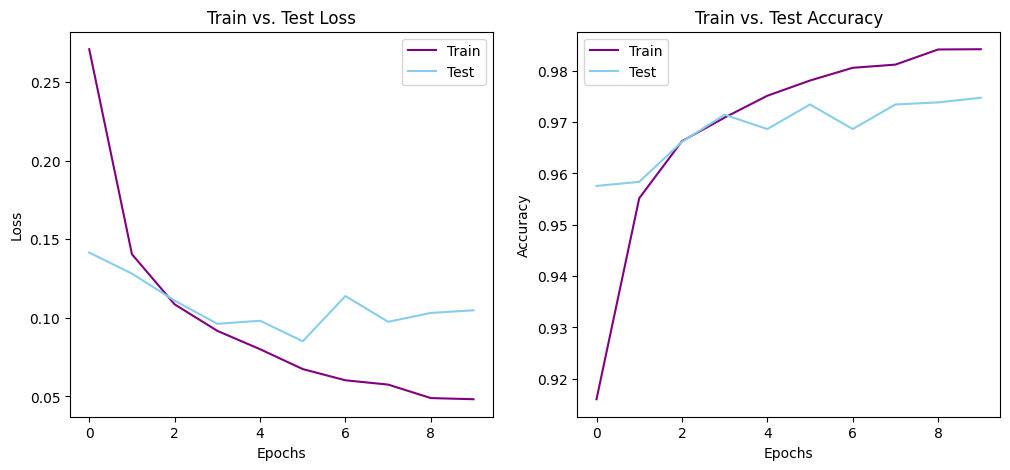

In [ ]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

Changing the optimizer from SGD to adam, leads to a higher accuracy as well as a significantly lower loss

## change batch size

* if we set the batch size to 1 instead of 32 the programm runs for a signifiantly longer time, this shows us why batching is important

## Combination


In [8]:
# model
layer_sizes = [256,256, 256]
mnistModel = MNIST_Model(layer_sizes)

# training
loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.1
optimizer = tf.keras.optimizers.Adam(learning_rate)
num_epochs = 10

train_losses, train_accuracies, test_losses, test_accuracies = train_loop(mnistModel, train_data, test_data, loss_func, optimizer, num_epochs)

 After epoch 0 the accuracy is: 0.10273562300319489
 After epoch 1 the accuracy is: 0.09584664536741214
 After epoch 2 the accuracy is: 0.0983426517571885
 After epoch 3 the accuracy is: 0.10283546325878594
 After epoch 4 the accuracy is: 0.11351837060702875
 After epoch 5 the accuracy is: 0.11351837060702875
 After epoch 6 the accuracy is: 0.09844249201277955
 After epoch 7 the accuracy is: 0.10103833865814696
 After epoch 8 the accuracy is: 0.09804313099041534
 After epoch 9 the accuracy is: 0.11331869009584665


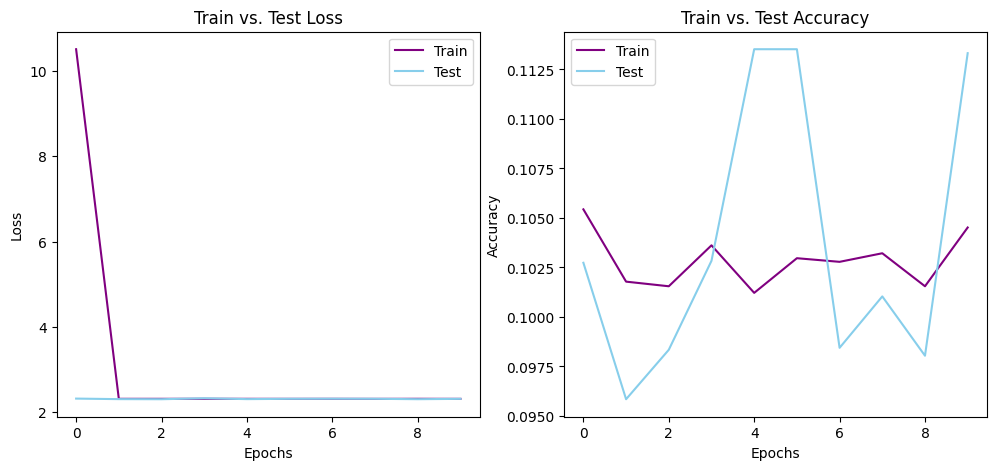

In [9]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

In [10]:
# model
layer_sizes = [256,256, 256]
mnistModel = MNIST_Model(layer_sizes)

# training
loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate)
num_epochs = 10

train_losses, train_accuracies, test_losses, test_accuracies = train_loop(mnistModel, train_data, test_data, loss_func, optimizer, num_epochs)

 After epoch 0 the accuracy is: 0.8882787539936102
 After epoch 1 the accuracy is: 0.9186301916932907
 After epoch 2 the accuracy is: 0.9101437699680511
 After epoch 3 the accuracy is: 0.9231230031948882
 After epoch 4 the accuracy is: 0.9181309904153354
 After epoch 5 the accuracy is: 0.9026557507987221
 After epoch 6 the accuracy is: 0.9263178913738019
 After epoch 7 the accuracy is: 0.9172324281150159
 After epoch 8 the accuracy is: 0.9184305111821086
 After epoch 9 the accuracy is: 0.928314696485623


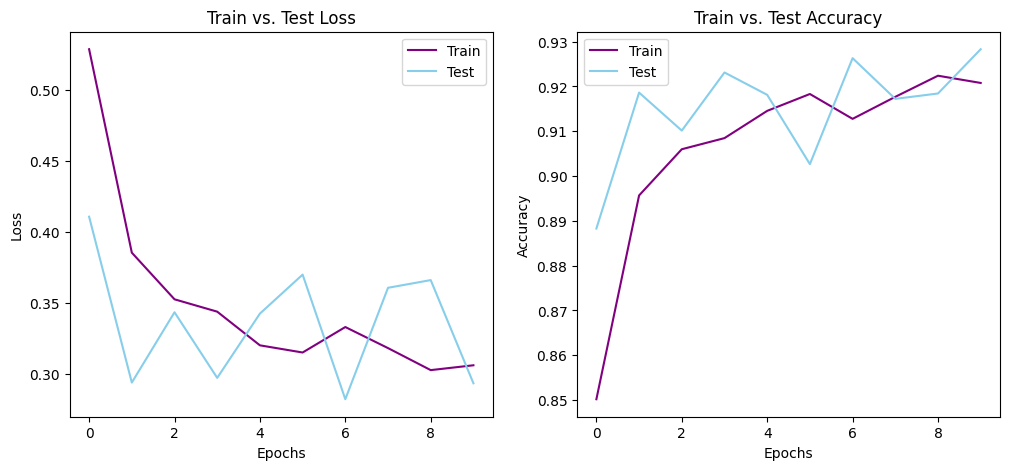

In [11]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

In [12]:
# model
layer_sizes = [256,256]
mnistModel = MNIST_Model(layer_sizes)

# training
loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate)
num_epochs = 10

train_losses, train_accuracies, test_losses, test_accuracies = train_loop(mnistModel, train_data, test_data, loss_func, optimizer, num_epochs)

 After epoch 0 the accuracy is: 0.9067492012779552
 After epoch 1 the accuracy is: 0.9054512779552716
 After epoch 2 the accuracy is: 0.9178314696485623
 After epoch 3 the accuracy is: 0.9213258785942492
 After epoch 4 the accuracy is: 0.9243210862619808
 After epoch 5 the accuracy is: 0.8853833865814696
 After epoch 6 the accuracy is: 0.8985623003194888
 After epoch 7 the accuracy is: 0.9139376996805112
 After epoch 8 the accuracy is: 0.9206269968051118
 After epoch 9 the accuracy is: 0.9199281150159745


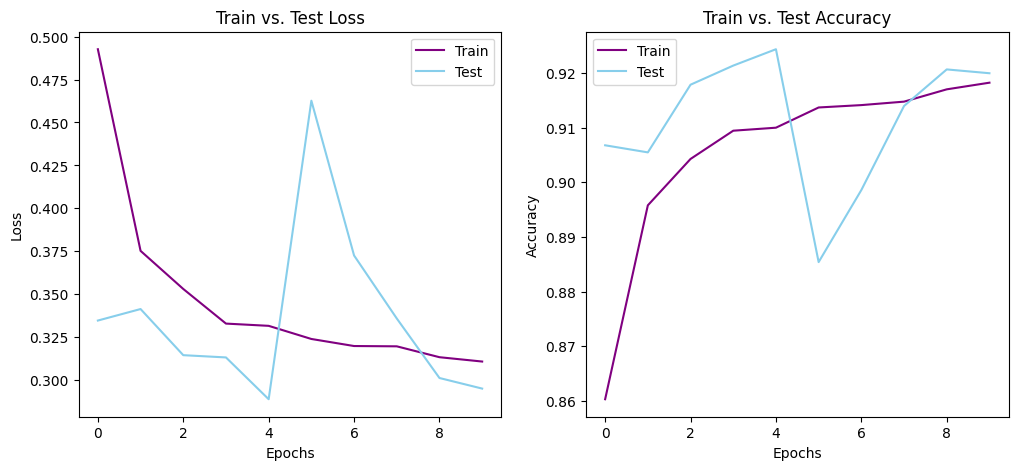

In [13]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

For changing a combination of parameters, I chose to use the Adam optimizer, since if only the optimizer is changed to Adam, I got higher accuracies and lower losses. But if I combine the Adam optimizer with changing the learning rate or the layer sizes, we get lower accuracies. Therefore, the SGD optimizer works better for this kind of task.